In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp
from glob import glob as lsdir
import os
import re
import datetime as dt
import plotly_express as px

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

# Read in data

In [2]:
fname = 'data/UVLTDataAnalysis.xls'
data = pd.read_excel(fname)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## Examining the raw data

In [3]:
data.head()

,ContactID,FirstName,LastName,City,State,ZipCode,TownID,Town,LandOwnerTownID,DeceasedDate,...,E-2010-11,E-2011-12,E-2012-13,E-2013-14,E-2014-15,E-2015-16,E-2016-17,E-2017-18,E-2018-19,E-2019-20
0,1544,Charles ...,Pitman,Chapel Hill,NC,27517,60,All Other Towns,0,NaT,...,0,0,0,0,0,0,0,0,0,0
1,1545,Pat,Reed,Lebanon,NH,03766,20,Lebanon,0,NaT,...,0,0,0,0,0,0,0,0,0,0
2,1546,David,Davenport,New London,NH,03257,61,All Other Towns NH,0,NaT,...,0,0,0,0,0,0,0,0,0,0
3,1547,Patricia,Stevens,Ascutney,VT,05030,41,Weathersfield,41,NaT,...,0,0,0,0,0,0,0,0,0,0
4,1548,Margaret Elizabeth,Stevens,Springfield,VT,05156,34,Springfield,0,2016-05-08,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.columns.values

array(['ContactID', 'FirstName', 'LastName', 'City', 'State', 'ZipCode',
       'TownID', 'Town', 'LandOwnerTownID', 'DeceasedDate',
       'DeceasedDateYN', 'U_Tot_Amt', 'U_Tot_Cnt', 'U-2000-01',
       'U-2001-02', 'U-2002-03', 'U-2003-04', 'U-2004-05', 'U-2005-06',
       'U-2006-07', 'U-2007-08', 'U-2008-09', 'U-2009-10', 'U-2010-11',
       'U-2011-12', 'U-2012-13', 'U-2013-14', 'U-2014-15', 'U-2015-16',
       'U-2016-17', 'U-2017-18', 'U-2018-19', 'U-2019-20', 'R-Tot-Amt',
       'R-Tot-Cnt', 'R-2000-01', 'R-2001-02', 'R-2002-03', 'R-2003-04',
       'R-2004-05', 'R-2005-06', 'R-2006-07', 'R-2007-08', 'R-2008-09',
       'R-2009-10', 'R-2010-11', 'R-2011-12', 'R-2012-13', 'R-2013-14',
       'R-2014-15', 'R-2015-16', 'R-2016-17', 'R-2017-18', 'R-2018-19',
       'R-2019-20', 'V-Tot-Cnt', 'V-2000-01', 'V-2001-02', 'V-2002-03',
       'V-2003-04', 'V-2004-05', 'V-2005-06', 'V-2006-07', 'V-2007-08',
       'V-2008-09', 'V-2009-10', 'V-2010-11', 'V-2011-12', 'V-2012-13',
       'V-2

## How much data are we working with?

In [5]:
data.shape

(13273, 97)

# Donation timeline analysis

Leading up to a donation, what sorts of patterns do we see?  For example, conditioned on donating in the current year, how much did people give in previous years?

Things to explore:
- Any donation amount vs. weighting bigger donations more vs. splitting into donation "quartiles"
- Looking at (U)nrestricted, (R)estricted, (V)olounteer, and (E)vent attendance "donations"
- Look to see whether the distributions are (roughly) unimodal or multi-modal
- Possibly break this down by geographic area

# Data wrangling

We will form these predictions using the following information from `data/UVLTDataAnalysis.xls`:
- Past history of unrestricted donations, restricted donations, volunteering, and event attendance for all years prior to the "current" year (we'll generate these histories for each year we have data for)
- Whether or not the person owns conserved land.  Assumption: land ownership did not change over the indicated period.
- Where the person's conserved land is located (if applicable). Assumption: land ownership did not change over the indicated period.
- Whether the person is still alive.

In [6]:
years = np.arange(2001, 2021) #years to include in analysis
def get_start_year(x):
    try:
        return int(re.search('-\d{4}-', x).group()[1:-1])
    except:
        return np.nan #no year found

def get_deceased_year(x, maxyear=np.inf):
    if type(x) == pd._libs.tslib.Timestamp:
        y = x.year
    elif np.isscalar(x):
        try:
            y = int(x)
        except:
            return np.nan
        
    try:
        if y < maxyear:
            return y
        else:            
            return np.nan
    except:        
        return np.nan #not a timestamp

In [7]:
#preprocessing
x = data.copy()
x.set_index('ContactID', inplace=True)
x.drop(['FirstName', 'LastName', 'City', 'TownID', 'Town', 'DeceasedDateYN'], axis=1, inplace=True)
x.drop(data.columns.values[np.where(np.array(['Tot' in x for x in data.columns.values]))[0]], axis=1, inplace=True)
x['DeceasedDate'] = x['DeceasedDate'].apply(get_deceased_year)

In [8]:
x.head()

,State,ZipCode,LandOwnerTownID,DeceasedDate,U-2000-01,U-2001-02,U-2002-03,U-2003-04,U-2004-05,U-2005-06,...,E-2010-11,E-2011-12,E-2012-13,E-2013-14,E-2014-15,E-2015-16,E-2016-17,E-2017-18,E-2018-19,E-2019-20
ContactID,,,,,,,,,,,,,,,,,,,,,
1544,NC,27517,0,NaN,0.0,50.0,21.95,100.0,200.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1545,NH,03766,0,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1546,NH,03257,0,NaN,25.0,25.0,50.00,100.0,100.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1547,VT,05030,41,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1548,VT,05156,0,2016.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## "Donation triggered average"

Conditioned on having donated in a given year, what does the historical data leading up to the current year look like?  Idea:

- For each year:
  - Split data into current year ("current") and data prior to the current year ("historical")
  - Adjust deceased date according to whether it would have been known (or not) in the current year

In [9]:
def get_current_and_historical_data(df, year):
    #historical data
    x = df[['State', 'ZipCode', 'LandOwnerTownID', 'DeceasedDate']].copy()
    x['DeceasedDate'] = x['DeceasedDate'].apply(lambda i: get_deceased_year(i, maxyear=year)) #remove all deaths before the given year    
    
    inds = np.array(list(map(get_start_year, df.columns.values))) < year
    x[df.columns.values[inds]] = df.iloc[:, inds]
    
    #current year
    inds = np.array(list(map(get_start_year, df.columns.values))) == year
    y = df[df.columns.values[inds]].copy()
    
    return x, y

In [10]:
historical, current = get_current_and_historical_data(x, 2010)

In [11]:
historical.head()

,State,ZipCode,LandOwnerTownID,DeceasedDate,U-2000-01,U-2001-02,U-2002-03,U-2003-04,U-2004-05,U-2005-06,...,E-2000-01,E-2001-02,E-2002-03,E-2003-04,E-2004-05,E-2005-06,E-2006-07,E-2007-08,E-2008-09,E-2009-10
ContactID,,,,,,,,,,,,,,,,,,,,,
1544,NC,27517,0,NaN,0.0,50.0,21.95,100.0,200.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1545,NH,03766,0,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1546,NH,03257,0,NaN,25.0,25.0,50.00,100.0,100.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1547,VT,05030,41,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1548,VT,05156,0,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
current.head()

,U-2010-11,R-2010-11,V-2010-11,E-2010-11
ContactID,,,,
1544,0.0,0.0,0,0
1545,0.0,0.0,0,0
1546,0.0,0.0,0,0
1547,0.0,0.0,0,0
1548,0.0,0.0,0,0


### Formatting data to facilitate donation-triggered averaging

We'll create a dataframe where each contactID is repeated nyears-1 times.  The `U*`, `R*`, `V*`, and `E*` columns should be renamed to `U-10`, `U-9`, etc. indicated the number of years *prior* to the prediction year (everything before the earliest year with data should be set to nans).  Also include `U`, `R`, `V`, and `E` columns indicating the values of those columns on the prediction year.

In [13]:
def to_relative_years(df):
    years = np.array(list(map(get_start_year, df.columns.values)))
    maxyear = np.nanmax(years)
    minyear = np.nanmin(years)
    
    mapper = {}
    df = df.copy()
    if minyear == maxyear: #only one year; drop all years
        for c in df.columns.values[~np.isnan(years)]:
            mapper[c] = c[:-8]        
    else:
        for i, y in enumerate(years):
            if not np.isnan(y):
                c = df.columns.values[i]
                mapper[c] = c[:-7] + str(int(maxyear - y + 1))
    
    df.rename(mapper, inplace=True, axis=1)
    return df

In [14]:
columns = ['State', 'ZipCode', 'LandOwnerTownID', 'DeceasedDate']
categories = ['U', 'R', 'V', 'E']
for c in categories:
    columns.extend(list(map(lambda x: f'{c}-{x}', np.arange(len(years), 0, -1))))
columns.extend(categories)

In [15]:
df = pd.DataFrame(index=['ContactID'], columns=columns, data=[])

In [16]:
for y in years[1:-1]: #skip the first year (no history) and last year (no future data)
    next_historical, next_current = get_current_and_historical_data(x, y)
    next_merged = pd.concat([to_relative_years(next_historical), to_relative_years(next_current)], axis=1, sort=False)
    df = pd.concat([df, next_merged], axis=0, copy=True, sort=False)

In [17]:
#re-order columns
df = df[columns]

#drop nans in first row
df.drop(index=['ContactID'], inplace=True)

#rename index 
df.index.names = ['ContactID']

In [18]:
df.head()

,State,ZipCode,LandOwnerTownID,DeceasedDate,U-20,U-19,U-18,U-17,U-16,U-15,...,E-6,E-5,E-4,E-3,E-2,E-1,U,R,V,E
ContactID,,,,,,,,,,,,,,,,,,,,,
1544,NC,27517,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,21.95,0,0,0
1545,NH,03766,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0.00,0,0,0
1546,NH,03257,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,50.00,0,0,0
1547,VT,05030,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0.00,0,0,0
1548,VT,05156,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0.00,0,0,0


In [19]:
# plot the weighted average donation history (of each type),
# conditioned on having given a U, R, V, or E donation in the current year
ignore_columns = ['State', 'ZipCode', 'LandOwnerTownID', 'DeceasedDate']
donation_types = ['U', 'R', 'V', 'E']

def weighted_average(x, weights):
    warnings.simplefilter('ignore')
    x = np.array(x, dtype=np.float)
    weights = np.array(weights, dtype=np.float)
    
    weighted_vals = np.multiply(x, weights)
    return np.divide(np.nansum(weighted_vals), np.sum(weights[~np.isnan(weighted_vals)]))

def binarized_average(x, weights):
    return weighted_average(x, weights > 0)

def weighted_donation_probability(x, weights):
    return weighted_average(x > 0, weights)

def binarized_donation_probability(x, weights):
    return weighted_average(x > 0, weights > 0)

def donation_triggered_average(data, ignore_columns, donation_types, summary_fun=weighted_average):
    x = []
    columns = data.columns.values[np.where([(not x in ignore_columns) for x in data.columns.values])[0]][:-4]
    
    for d in donation_types:        
        donation_columns = columns[[f'{d}-' in x for x in columns]]
        next_df = pd.DataFrame(index=donation_types, columns=donation_columns, data=[])  
        for i in donation_types:            
            next_df.loc[i, :] = data[next_df.columns].apply(lambda x: summary_fun(x, data[i]))        
        x.append(next_df)
    return x

In [20]:
units = ['\$', '\$', 'hrs', 'count']

def dta_plot(data, ignore_columns, donation_types, units, summary_function):
    dta = donation_triggered_average(df, ignore_columns, donation_types, summary_fun=summary_function)
    
    for i, d1 in enumerate(donation_types): #plot ID-- what is being plotted leading up to moment of donation
        for j, d2 in enumerate(donation_types): #plot a line for each type of donation being predicted
            plt.plot(-(years[-1] - years + 1), dta[i].loc[d2, :].values)
            plt.xlabel('Years relative to donation')
            plt.ylabel(f'Donation amount ({units[i]})')
            plt.title(f'{d1} donations')
        if i == 0:
            plt.legend([f'Preceding {x} donation' for x in donation_types])
        plt.show()

## Plot donation-triggered history using weighted averages

In this analysis, bigger donations are weighted more in the estimates and summaries.  Each plot reflects how people make a particular type of donation -- (U)nrestricted, (R)estricted, (V)olunteer, or (E)vent attendance "donations" -- in the years leading up to each type of donation.  For example, the "U donations" plots show the history of unrestricted donations.  Each line in the plot shows what U donations look like in the years preceeding U donations (blue), R donations (orange), V donations (green), and E donations (red).

### Note

Because this analysis gives more weights to larger donations, we are effectively looking at the donation histories leading up to *bigger* donation events.  In other words, if the goal is to maximize donation size per donor, these plots give some insights into who might be most likely to make large donations (of each type).

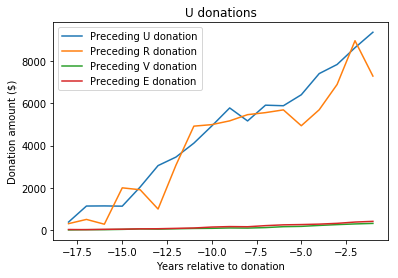

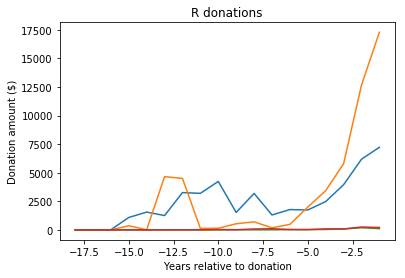

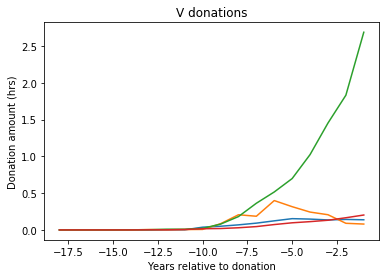

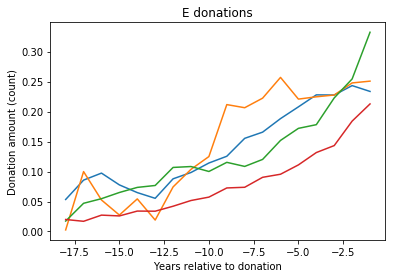

In [21]:
dta_plot(df, ignore_columns, donation_types, units, weighted_average)

## Results

### Unrestricted donations

For people who make the largest donations, unrestricted donations tend to increase yearly preceeding both U and R donations.  This means that large donors (of either unrestricted or restricted funds) tend to continue giving money from year to year, and the amount of unrestricted money they donate increases from year to year.  However, leading up to V or E "donations" these same donors tend *not* to give much unrestricted money.  This could suggest that volunteering or event attendence tends to preceed large donations, but that large donors don't tend to give large unrestricted donations prior to volunteering or attending events.

### Restricted donations

Restricted donations tend to follow a similar pattern to unrestricted donations.  Large restricted donors in a given year tend to have also given large restricted donations in previous years.

### Volunteer donations

People who volunteer the most also tend to have volunteered in previous years, and they tend to increase their involvement over time.  They also tend to (modestly) increase the number of events they attend.  Interestignly, monetary donations from the biggest volunteers tend to *decrease* in the years leading up to big volunteer pushes; this is true for both unrestricted and restricted donations.

### Event "donations"

People who attend the most events tend to also donate (unrestricted and restricted) money, volunteer, and attend other events, in the years leading up to event attendance.  In other words, the biggest event participants seem to be people who are already involved and actively contributing to UVLT.

---

## Plot donation-triggered history using binarized averages

In this analysis, *any* donations are weighted equally, regardless of their size.  This plot shows the simple average donation amounts of each donation type, leading up to each type of donation.

Each plot reflects how people make a particular type of donation -- (U)nrestricted, (R)estricted, (V)olunteer, or (E)vent attendance "donations" -- in the years leading up to each type of donation.  For example, the "U donations" plots show the history of unrestricted donations.  Each line in the plot shows what U donations look like in the years preceeding U donations (blue), R donations (orange), V donations (green), and E donations (red).

### Notes

Because this analysis weights all donations equally, this analysis gives insights into what the "average" or "typical" UVLT donor might give.  However, when the distribution of donations is highly skewed (e.g. a small number of donors give substantially more than the rest) it can have an outsized effect on the avearge, providing a potentially skewed vision of the historical trends.

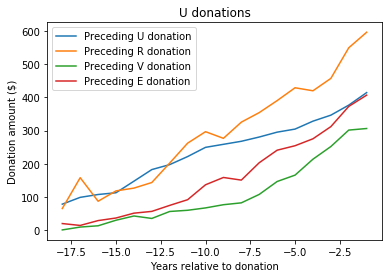

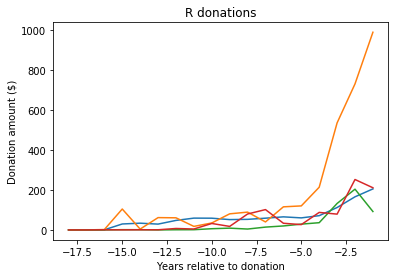

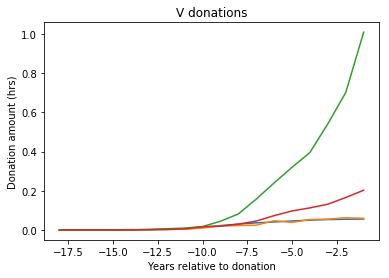

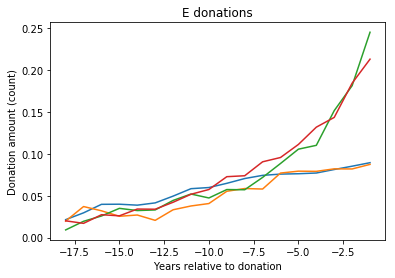

In [22]:
dta_plot(df, ignore_columns, donation_types, units, binarized_average)

## Results

### Unrestricted donations

For people who make the *any* donations, unrestricted donations tend to increase yearly preceeding all other types of donations.

both U and R donations.  This means that large donors (of either unrestricted or restricted funds) tend to continue giving money from year to year, and the amount of unrestricted money they donate increases from year to year.  However, leading up to V or E "donations" these same donors tend *not* to give much unrestricted money.  This could suggest that volunteering or event attendence tends to preceed large donations, but that large donors don't tend to give large unrestricted donations prior to volunteering or attending events.

### Restricted donations

Restricted donations tend to follow a similar pattern to unrestricted donations.  Large restricted donors in a given year tend to have also given large restricted donations in previous years.

### Volunteer donations

People who volunteer the most also tend to have volunteered in previous years, and they tend to increase their involvement over time.  They also tend to (modestly) increase the number of events they attend.  Interestignly, monetary donations from the biggest volunteers tend to *decrease* in the years leading up to big volunteer pushes; this is true for both unrestricted and restricted donations.

### Event "donations"

People who attend the most events tend to also donate (unrestricted and restricted) money, volunteer, and attend other events, in the years leading up to event attendance.  In other words, the biggest event participants seem to be people who are already involved and actively contributing to UVLT.

---

## Plot historical probability of donations, using weighted averages

Plot the probability of donation (of any size) by year, weighting bigger donations more in the calculations

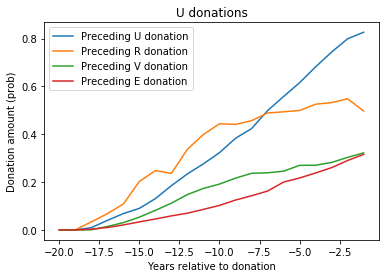

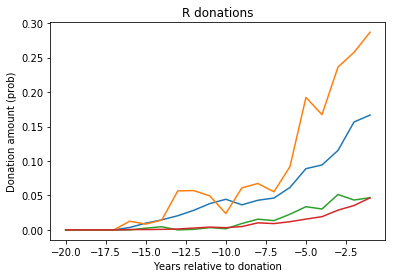

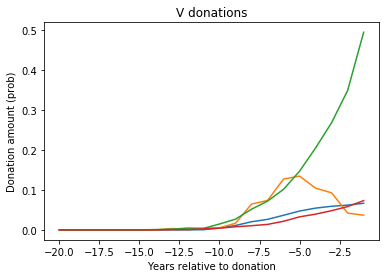

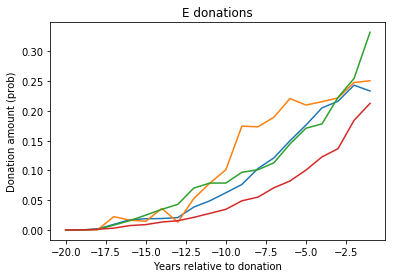

In [23]:
binary_units = ['prob']*len(donation_types)
dta_plot(df, ignore_columns, donation_types, binary_units, weighted_donation_probability)

## Plot historical probability of donations, using binarized averages

Plot the probability of donation (of any size) by year, counting all donations equally in the calculations

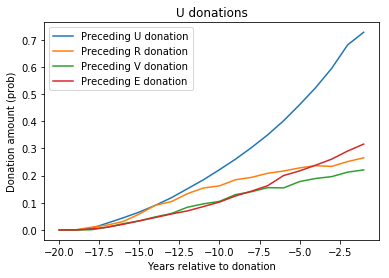

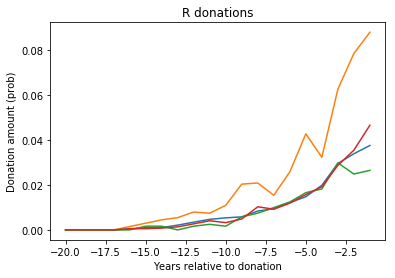

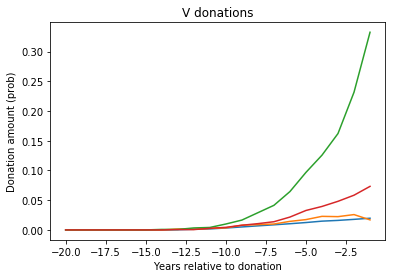

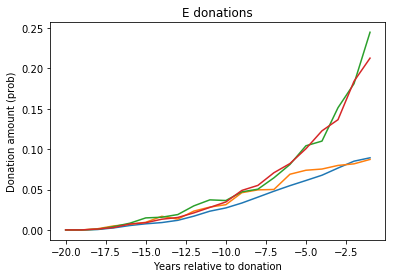

In [24]:
dta_plot(df, ignore_columns, donation_types, binary_units, binarized_donation_probability)

# Summary and interpretation

Each plot reflects how people make a particular type of donation -- (U)nrestricted, (R)estricted, (V)olunteer, or (E)vent attendance "donations" -- in the years leading up to each type of donation.  For example, the "U donations" plots show the history of unrestricted donations.  Each line in the plot shows what U donations look like in the years preceeding U donations (blue), R donations (orange), V donations (green), and E donations (red).

Overall, people tend to donate roughly similarly from year to year, and they generally increase the amount they are donating over time.

## Unrestricted donations



